In [1]:
library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(stringr)
library(ggstream)
library(ggrepel)
library(ggh4x)
library(broom)
is_dark_color <- function(hex) {
  rgb <- col2rgb(hex)
  
  luminance <- 0.299 * rgb[1,] + 0.587 * rgb[2,] + 0.114 * rgb[3,]
  
  if(luminance < 128){
  
  return('white')
      
  }else{return('black')}
}
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_annotation$label<-gsub(" cell",'',color_annotation$label)
color_vector <- setNames(color_annotation$color, color_annotation$label)

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘broom’ was built under R version 4.3.3”


# Read Scores

In [ ]:
mesenteric_lymph_node<-read.csv("04_Composite_Score/Tissue_aging_followup/mesenteric_lymph_node.csv")
mesenteric_lymph_node$Dataset<-"Mesenteric\nLymph Node"

thoracic_lymph_node<-read.csv("04_Composite_Score/Tissue_aging_followup/thoracic_lymph_node.csv")
thoracic_lymph_node$Dataset<-"Thoracic\nLymph Node"

In [4]:
df_combined<-rbind(mesenteric_lymph_node,thoracic_lymph_node)

In [5]:
df_combined$celltype_wrapped <- str_wrap(df_combined$celltype, width = 16)

In [6]:
options(repr.plot.width = 100/25.4, repr.plot.height = 50/25.4)
df_combined$celltype <- gsub(" cell", '', df_combined$celltype)
names(color_vector)<-str_wrap(names(color_vector), width = 16)
df_combined$celltype_wrapped <- str_wrap(df_combined$celltype, width = 16)

strip_colors <- setNames(
  color_vector[ unique(df_combined$celltype_wrapped) ],
  unique(df_combined$celltype_wrapped)
)

Warning message:
“There were 8 warnings in `summarize()`.
The first warning was:
ℹ In argument: `stat = list(tidy(cor.test(Ages,
  composite_score_sum_scaled_mean, method = "spearman")))`.
ℹ In group 1: `Dataset = "Mesenteric\nLymph Node"` and `celltype_wrapped = "CM
  CD4 T"`.
Caused by warning in `cor.test.default()`:
! Cannot compute exact p-value with ties
ℹ Run `dplyr::last_dplyr_warnings()` to see the 7 remaining warnings.”
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


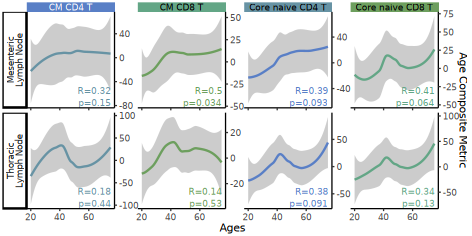

In [7]:
p <- ggplot(
  data = df_combined ,
  aes(
    x     = Ages,
    y     = composite_score_sum_scaled_mean,
    label = celltype_wrapped,
    color = celltype_wrapped,
    group = celltype_wrapped
  )
) +
  geom_smooth(se = TRUE, alpha = 0.5, span = 0.8, linewidth = 0.5) +
  
  theme_classic(base_size = 6) +
  scale_color_manual(values = color_vector) +
  ylab("Age Composite Metric") +
  xlab("Ages") +
  facet_grid2(
    Dataset ~ celltype_wrapped,
    scales        = "free_y",
    independent   = "y",
    axes          = "all",
    remove_labels = "x", switch = "y",
    strip         = strip_themed(
      background_x = elem_list_rect(fill = strip_colors, color = NA),
      text_x       = elem_list_text(color = unlist(lapply(strip_colors, is_dark_color)))
    )
  ) +
  theme(
    legend.position   = "none",
    plot.margin       = grid::unit(c(0.5, 0.5, 0.5, 0.5), "mm"),
    panel.spacing.x   = unit(0.01, "mm"),
    panel.spacing.y   = unit(0.5,  "mm"),
    panel.grid.major  = element_blank(),
    panel.grid.minor  = element_blank(),
    strip.text.x      = element_text(size = 5, margin = margin(t = 0.5, b = 0.5, unit = "pt"))
  )  + theme(
  strip.background.x = element_rect(colour = NA),
)+ scale_y_continuous(position = "right") 



label_df <- df_combined %>%
  group_by(Dataset, celltype_wrapped) %>%
  summarize(
    stat = list(tidy(cor.test(Ages, composite_score_sum_scaled_mean, method="spearman"))),
    .groups = "drop"
  ) %>%
  unnest(stat) %>%
  transmute(
    Dataset,
    celltype_wrapped,
    x     = Inf,
    y     = -Inf,
    label = paste0("R=", signif(estimate, 2), "\np=", signif(p.value, 2))
  )

p_final <- p +
  geom_text(
    data        = label_df,
    aes(
      x               = x,
      y               = y,
      label           = label,
      color           = celltype_wrapped
    ),
    inherit.aes = FALSE,
    hjust       = 1.1,
    vjust       = -0.1,
    size        = 1.76,
    show.legend = FALSE
  )
p_final

In [8]:
ggsave('FigureI.pdf',p_final, width = 100/25.4, 
       height = 40/25.4)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


In [9]:
df_combined$RNA_Age_Metric_Up<-df_combined$composite_score_sum_scaled_mean
write.csv(df_combined %>% select(sample_id,Ages,celltype,tissue,RNA_Age_Metric_Up),
          "/home//workspace/Source_Data/Fig2i.csv", row.names=FALSE)